# Vault of vaults strategy

- Based on `04`
- Tweak basket construction criteria to bump the yield a bit

# Set up

Set up Trading Strategy data client.


In [117]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode, set_notebook_logging

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


logger = logging.getLogger("strategy")



Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Chain configuration

- Choose target chains and their vults

In [118]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.chain import ChainId
from tradingstrategy.lending import LendingProtocolType

CHAIN_ID = ChainId.arbitrum


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
match CHAIN_ID:
    case ChainId.arbitrum:

        EXCHANGES = ("uniswap-v2", "uniswap-v3")
        SUPPORTING_PAIRS = [
            (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
        ]
        LENDING_RESERVES = None
        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[CHAIN_ID].lower()


        VAULTS = [
            (ChainId.arbitrum, "0x58bfc95a864e18e8f3041d2fcd3418f48393fe6a"), # Plutus Hedge Token
            (ChainId.arbitrum, "0x959f3807f0aa7921e18c78b00b2819ba91e52fef"), # gmUSDC
            (ChainId.arbitrum, "0xd3443ee1e91af28e5fb858fbd0d72a63ba8046e0"), # gTrade (Gains) USDC
            (ChainId.arbitrum, "0x75288264fdfea8ce68e6d852696ab1ce2f3e5004"), # Hype++
            (ChainId.arbitrum, "0x4b6f1c9e5d470b97181786b26da0d0945a7cf027"), # Hypertrim USDC
            (ChainId.arbitrum, "0x0b2b2b2076d95dda7817e785989fe353fe955ef9"), # Staked USDai
            (ChainId.arbitrum, "0x64ca76e2525fc6ab2179300c15e343d73e42f958"), # Clearstar high yielsd USDC
            (ChainId.arbitrum, "0x7e97fa6893871a2751b5fe961978dccb2c201e65"), # Gauntlet
            (ChainId.arbitrum, "0x1a996cb54bb95462040408c06122d45d6cdb6096"), # Fluid
            (ChainId.arbitrum, "0xa91267a25939b2b0f046013fbf9597008f7f014b"), # IPOR USDC Arbirum optimise
            (ChainId.arbitrum, "0x05d28a86e057364f6ad1a88944297e58fc6160b3"), # Euler Arbitrum Yield USDC 
            (ChainId.arbitrum, "0x20d419a8e12c45f88fda7c5760bb6923cee27f98"), # Ostium liquidity provider

            # Some smaller entries to mix in
            # (ChainId.arbitrum, "0xc8248953429d707c6a2815653eca89846ffaa63b"), # Curve LLAMMA asdCRV / crvUSD
            (ChainId.arbitrum, "0xf63b7f49b4f5dc5d0e7e583cfd79dc64e646320c"), # Auto finance Tokemak ARB/USDC
            # (ChainId.arbitrum, "0xeeaf2ccb73a01deb38eca2947d963d64cfde6a32"), # Curve LLAMMA CRV / crvUSD
            (ChainId.arbitrum, "0xe5d6eb448ac5a762c1ebe8cd1692b9cd08025176"), # DAMM stablecoin fund

        ]        

        BENCHMARK_PAIRS = [
            (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
        ]

        # Exclude Euro vaults, etc.
        # ALLOWED_VAULT_DENOMINATION_TOKENS = {"USDC", "USDT", "USDC.e"}
        ARBITRUM_STABLECOIN_ADDRESSES = {
            "USDC": "0xaf88d065e77c8cC2239327C5EDb3A432268e5831",
            "USDT": "0xFd086bC7CD5C481DCC9C85ebE478A1C0b69FCbb9",
            "USDC.e": "0xff970a61a04b1ca14834a43f5de4533ebddb5cc8",
            # "crvUSD": "0x498bf2b1e120fed3ad3d42ea2165e9b73f99c1e5",
            "USDai": "0x0A1a1A107E45b7Ced86833863f482BC5f4ed82EF",
            "USD₮0": "0xFd086bC7CD5C481DCC9C85ebE478A1C0b69FCbb9",  # Same as USDT
        }
        ALLOWED_VAULT_DENOMINATION_TOKENS = set(ARBITRUM_STABLECOIN_ADDRESSES.keys())
    
    case ChainId.base:
        raise NotImplementedError()
    case ChainId.ethereum:
        raise NotImplementedError()
    case ChainId.binance:
        raise NotImplementedError()
    case ChainId.avalanche:
        raise NotImplementedError()
    case _:
        raise NotImplementedError(f"Chain not supported: {CHAIN_ID}")

## Parameters

- Collection of parameters used in the calculations

In [119]:
import datetime

import pandas as pd


from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting

from tradeexecutor.utils.jupyter_notebook_name import get_notebook_id


class Parameters:

    id = get_notebook_id(globals())

    # We trade 1h candle
    candle_time_bucket = TimeBucket.d1
    cycle_duration = CycleDuration.cycle_7d
    
    chain_id = CHAIN_ID
    exchanges = EXCHANGES
    
    #
    # Basket size, risk and balancing parametrs.
    #   
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 7  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 500.0  # Don't make buys less than this amount
    sell_rebalance_min_threshold = 100.0
    sell_threshold = 0.05  # Sell if asset is more than 5% of the portfolio
    per_position_cap_of_pool = 0.33  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.25 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    # How long rolling returns window in bars (days)
    # Needed to calculate weights
    rolling_returns_bars = 90

    min_tvl = 50_000  # Minimum TVL in the vault before it can be considered investable

    #     
    #
    # Backtesting only
    # Limiting factor: Aave v3 on Base starts at the end of DEC 2023
    #
    backtest_start = datetime.datetime(2025, 1, 1)
    backtest_end = datetime.datetime(2026, 1, 15)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=365*3)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [ ]:

from pathlib import Path
from typing import Callable
from tradingstrategy.pair import PandasPairUniverse


from eth_defi.vault.vaultdb import DEFAULT_RAW_PRICE_DATABASE

from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import filter_for_exchange_slugs
from tradingstrategy.utils.token_filter import filter_pairs_default
from tradingstrategy.utils.token_filter import filter_for_selected_pairs
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.alternative_data.vault import load_vault_database


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe
from tradeexecutor.strategy.pandas_trader.trading_universe_input import CreateTradingUniverseInput
from tradeexecutor.analysis.vault import display_vaults



# Hack to support vault data exposure to live trading universe creation
from dotenv import load_dotenv
load_dotenv(override=True)  # Loads variables from .env file


def create_trading_universe(
    input: CreateTradingUniverseInput,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset

    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    execution_context = input.execution_context
    client = input.client
    timestamp = input.timestamp
    parameters = input.parameters or Parameters  # Some CLI commands do not support yet passing this
    universe_options = input.universe_options

    if execution_context.live_trading:
        # Live trading, send strategy universe formation details
        # to logs
        debug_printer = logger.info
    else:
        # Jupyter notebook inline output
        debug_printer = print

    chain_id = parameters.chain_id

    debug_printer(f"Preparing trading universe on chain {chain_id.get_name()}")

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    # TODO: PandasPairUniverse(buidl_index=True) - speed this up by skipping index building
    all_pairs_df = client.fetch_pair_universe().to_pandas()
    pairs_df= filter_for_selected_pairs(
        all_pairs_df,
        SUPPORTING_PAIRS,
    )    

    debug_printer(f"We have total {len(all_pairs_df)} pairs in dataset and going to use {len(pairs_df)} pairs for the strategy")

    # Check which vaults we can include based on allowed deposit tokens for this backtest
    vault_universe = load_vault_database()
    total_vaults = vault_universe.get_vault_count()
    vault_universe = vault_universe.limit_to_vaults(VAULTS, check_all_vaults_found=False)
    vault_universe = vault_universe.limit_to_denomination(ALLOWED_VAULT_DENOMINATION_TOKENS, check_all_vaults_found=True)
    debug_printer(f"Loaded total {vault_universe.get_vault_count()} vaults from the total of {total_vaults} in vault database")

    # Default vault data bundle path for backtesting
    vault_bundled_price_data = DEFAULT_RAW_PRICE_DATABASE
    debug_printer(f"Using vault price data for backtesting from {vault_bundled_price_data}")

    dataset = load_partial_data(
        client=client,
        time_bucket=parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,
        lending_reserves=LENDING_RESERVES,
        vaults=vault_universe,
        vault_bundled_price_data=vault_bundled_price_data if not execution_context.live_trading else None,
        check_all_vaults_found=True,
    )

    debug_printer("Creating strategy universe with price feeds and vaults")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=PREFERRED_STABLECOIN,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
        forward_fill_until=timestamp,
    )

    # crvUSD etc. do not have backtesting paths yet
    strategy_universe.ignore_routing = True

    # Dump our vault data and check for data errors
    display_vaults(
        vault_universe,
        strategy_universe,
        execution_mode=execution_context.mode,
        printer=debug_printer,  
    )

    return strategy_universe


universe_input = CreateTradingUniverseInput(
    execution_context=notebook_execution_context,
    client=client,
    timestamp=None,
    parameters=parameters,
    universe_options=UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context),
    execution_model=None,
)

strategy_universe = create_trading_universe(universe_input)


print("Universe creation done")

df = display_strategy_universe(
    strategy_universe, 
    sort_key="base",
    sort_numeric=False,
    limit=75,
    show_token_risk=True,
    show_tokensniffer=True,
)

df = df.head(10)

from IPython.display import display, HTML
html_table = df.to_html(escape=False, classes='table table-striped')
display(HTML(html_table))


Preparing trading universe on chain Arbitrum One
We have total 387449 pairs in dataset and going to use 1 pairs for the strategy
Loaded total 14 vaults from the total of 20854 in vault database
Using vault price data for backtesting from /Users/moo/.tradingstrategy/vaults/cleaned-vault-prices-1h.parquet


Loading TVL/liquidity data for 1 pairs:   0%|          | 0/1 [00:00<?, ?it/s]

## Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [ ]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 15 assets
Category trading pairs 15
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [ ]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


@indicators.define()
def rolling_returns(
    close: pd.Series,
    rolling_returns_bars,
) -> pd.Series:
    """Calculate rolling returns over a period
    """
    lagged_close = close.shift(rolling_returns_bars)
    series = close / lagged_close - 1
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
    timestamp: pd.Timestamp,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.        
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        from tradingstrategy.utils.forward_fill import forward_fill
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_tvl": min_tvl, 
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series



@indicators.define(
    source=IndicatorSource.dependencies_only_per_pair,
    dependencies=[
        rolling_returns,
        inclusion_criteria,
    ]
)
def signal(
    rolling_returns_bars: int,
    candle_time_bucket: TimeBucket,
    min_tvl: USDollarAmount,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate weighting criteria ("signal") as the past returns of the rolling returns window.

    Only returns signal if the pair meets inclusion criteria at that timepoint.
    """

    inclusion_criteria_series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_tvl": min_tvl,
        },
    )

    # A benchmark asset
    if not pair.is_vault():
        zeros = pd.Series(0, index=inclusion_criteria_series.index)
        return zeros

    rolling_returns_series = dependency_resolver.get_indicator_data(
        "rolling_returns",
        parameters={
            "rolling_returns_bars": rolling_returns_bars,
        },
        pair=pair,
    )
    # return rolling_returns_series

    # Create a mask where True means the pair is included at that timestamp
    pair_id = pair.internal_id
    inclusion_mask = inclusion_criteria_series.apply(lambda x: pair_id in x)
    
    smoothed_returns = rolling_returns_series.ewm(span=rolling_returns_bars).mean()

    # Set signal zero for the periods when the pair was not included
    return smoothed_returns * inclusion_mask


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
)

We have 9 indicators:


Reading cached indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusi…

Using indicator cache /Users/moo/.cache/indicators/arbitrum_1d_15_2024-01-18-2026-01-16_ff


Calculating indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusion_…

Calculating indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusion_…

# Trading universe charts

- Define charts used in backtesting and live execution



In [ ]:
from plotly.graph_objects import Figure
from tradeexecutor.strategy.chart.definition import ChartRegistry, ChartKind, ChartInput
from tradeexecutor.strategy.chart.renderer import ChartBacktestRenderingSetup
from tradeexecutor.strategy.chart.standard.trading_universe import available_trading_pairs
from tradeexecutor.strategy.chart.standard.trading_universe import inclusion_criteria_check 
from tradeexecutor.strategy.chart.standard.volatility import volatility_benchmark
from tradeexecutor.strategy.chart.standard.signal import signal_comparison as _signal_comparison
from tradeexecutor.strategy.chart.standard.signal import price_vs_signal
from tradeexecutor.strategy.chart.standard.vault import all_vaults_share_price_and_tvl
from tradeexecutor.strategy.chart.standard.vault import vault_position_timeline
from tradeexecutor.strategy.chart.standard.vault import all_vault_positions
from tradeexecutor.strategy.chart.standard.equity_curve import equity_curve
from tradeexecutor.strategy.chart.standard.equity_curve import equity_curve_with_drawdown
from tradeexecutor.strategy.chart.standard.performance_metrics import performance_metrics
from tradeexecutor.strategy.chart.standard.weight import volatile_weights_by_percent
from tradeexecutor.strategy.chart.standard.weight import volatile_and_non_volatile_percent
from tradeexecutor.strategy.chart.standard.weight import equity_curve_by_asset
from tradeexecutor.strategy.chart.standard.weight import weight_allocation_statistics
from tradeexecutor.strategy.chart.standard.position import positions_at_end
from tradeexecutor.strategy.chart.standard.thinking import last_messages
from tradeexecutor.strategy.chart.standard.alpha_model import alpha_model_diagnostics
from tradeexecutor.strategy.chart.standard.profit_breakdown import trading_pair_breakdown
from tradeexecutor.strategy.chart.standard.trading_metrics import trading_metrics
from tradeexecutor.strategy.chart.standard.interest import lending_pool_interest_accrued
from tradeexecutor.strategy.chart.standard.interest import vault_statistics
from tradeexecutor.strategy.chart.standard.single_pair import trading_pair_positions
from tradeexecutor.strategy.chart.standard.single_pair import trading_pair_price_and_trades
from tradeexecutor.strategy.chart.standard.vault import all_vaults_share_price_and_tvl as _all_vaults_share_price_and_tvl


def equity_curve_with_benchmark(input: ChartInput) -> list[Figure]:
    """Add our benchmark token"""
    return equity_curve(
        input,
        benchmark_token_symbols=["ETH"],
    )


def all_vaults_share_price_and_tvl(input: ChartInput) -> list[Figure]:
    """Limit max_count"""
    return _all_vaults_share_price_and_tvl(
        input,
        max_count=2,
    )

def signal_comparison(input: ChartInput) -> list[Figure]:
    """Choose vaults only"""

    input = input.copy()
    input.pairs = [p for p in input.strategy_universe.iterate_pairs() if p.is_vault()]
    return _signal_comparison(
        input,
    )


# Define charts we use in backtesting and live trading
charts = ChartRegistry(default_benchmark_pairs=BENCHMARK_PAIRS)
charts.register(available_trading_pairs, ChartKind.indicator_all_pairs)
charts.register(inclusion_criteria_check, ChartKind.indicator_all_pairs)
charts.register(volatility_benchmark, ChartKind.indicator_multi_pair)
charts.register(signal_comparison, ChartKind.indicator_multi_pair)
charts.register(price_vs_signal, ChartKind.indicator_multi_pair)
charts.register(all_vaults_share_price_and_tvl, ChartKind.indicator_all_pairs)
charts.register(equity_curve_with_benchmark, ChartKind.state_all_pairs)
charts.register(equity_curve_with_drawdown, ChartKind.state_all_pairs)
charts.register(performance_metrics, ChartKind.state_all_pairs)
charts.register(volatile_weights_by_percent, ChartKind.state_all_pairs)
charts.register(volatile_and_non_volatile_percent, ChartKind.state_all_pairs)
charts.register(equity_curve_by_asset, ChartKind.state_all_pairs)
charts.register(weight_allocation_statistics, ChartKind.state_all_pairs)
charts.register(positions_at_end, ChartKind.state_all_pairs)
charts.register(last_messages, ChartKind.state_all_pairs)
charts.register(alpha_model_diagnostics, ChartKind.state_all_pairs)
charts.register(trading_pair_breakdown, ChartKind.state_all_pairs)
charts.register(trading_metrics, ChartKind.state_all_pairs)
charts.register(lending_pool_interest_accrued, ChartKind.state_all_pairs)
charts.register(vault_statistics, ChartKind.state_all_pairs)
charts.register(vault_position_timeline, ChartKind.state_single_vault_pair)
charts.register(all_vault_positions, ChartKind.state_single_vault_pair)
charts.register(trading_pair_positions, ChartKind.state_single_vault_pair)
charts.register(trading_pair_price_and_trades, ChartKind.state_single_vault_pair)
charts.register(inclusion_criteria_check, ChartKind.indicator_all_pairs)

# Chart rendering pre-backtest execution
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    backtest_end_at=Parameters.backtest_end,
)


## Available pairs

- Number of pairs available to trade every month


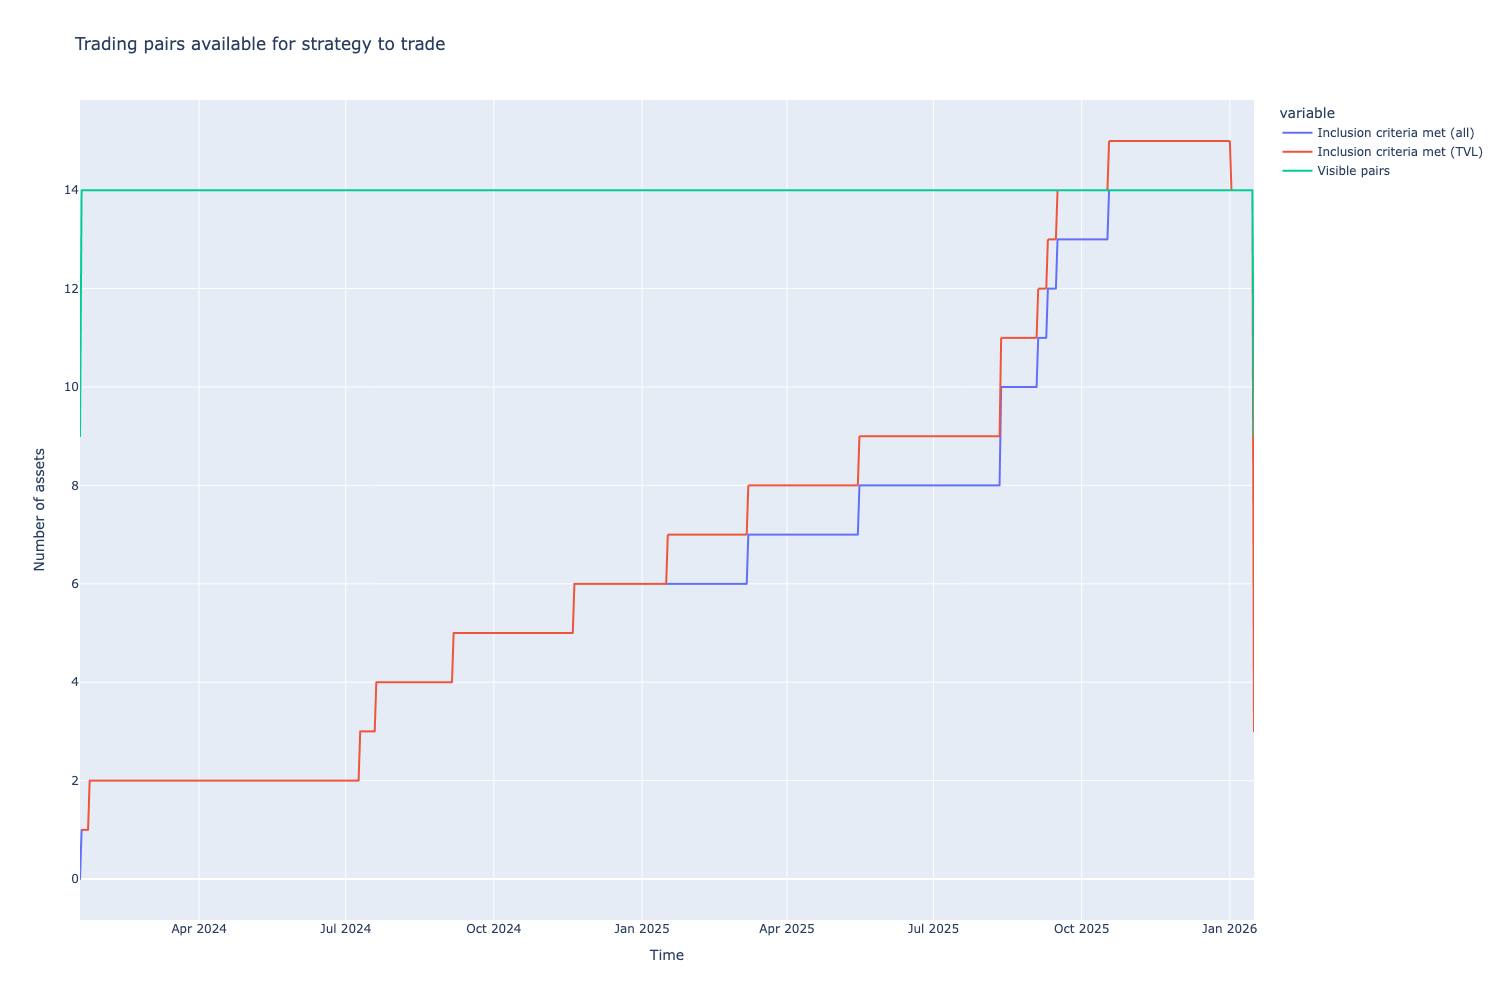

Inclusion criteria met (all)  Inclusion criteria met (TVL)  \
2026-01-12                            14                          14.0   
2026-01-13                            14                          14.0   
2026-01-14                            14                          14.0   
2026-01-15                            14                          14.0   
2026-01-16                             3                           3.0   

            Visible pairs  
2026-01-12             14  
2026-01-13             14  
2026-01-14             14  
2026-01-15             14  
2026-01-16              9

In [ ]:
fig, df = chart_renderer.render(available_trading_pairs, with_dataframe=True)
fig.show()
display(df.tail(5))

## Inclusion criteria checks

- Examine when different pairs got included and what was the pair status during the inclusion

In [ ]:

df = chart_renderer.render(inclusion_criteria_check)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df.head(5))


First appearances of 14 trading pairs, when they meet all inclusion criteria:


Included at                        Ticker          Venue  \
283455471  2024-01-19                        gmUSDC          umami   
276842208  2024-01-24   gTrade (Gains Network USDC)  gains-network   
282812566  2024-07-10                Fluid USD Coin          fluid   
283279256  2024-07-20   Ostium Liquidity Pool Vault         ostium   
276758859  2024-09-06  IPOR USDC Arbitrum Optimizer           ipor   

           TVL at inclusion    TVL at end  
283455471         74,836.20    115,099.45  
276842208        231,998.38 15,173,534.31  
282812566        100,011.11 61,779,638.17  
283279256        129,703.17 36,250,220.23  
276758859        688,693.24    327,884.66

## Signal comparison

- Weight signal for different vaults at the moment of time
- The signal is masked by the inclusion criteria


Rolling returns:


WETH-USDC  gUSDC-USDC  gmUSDC-USDC  fUSDC-USDC  oLP-USDC  \
timestamp                                                              
2026-01-12  -0.250827    0.025037     0.021845    0.007498  0.000581   
2026-01-13  -0.166224    0.024732     0.020641    0.007491 -0.000136   
2026-01-14  -0.138252    0.024584     0.018589    0.007456  0.001642   
2026-01-15  -0.134366    0.024206     0.017528    0.007393  0.021050   
2026-01-16        NaN    0.024137          NaN         NaN       NaN   

            ipUSDCfusion-USDC  HYPE++-USDC  plvHedge-USDC  sUSDai-USDai  \
timestamp                                                                 
2026-01-12           0.005393     0.025844       0.048923      0.022608   
2026-01-13           0.005358     0.025844       0.048923      0.022838   
2026-01-14           0.005353     0.025844       0.048923      0.022013   
2026-01-15           0.005326     0.025844       0.048923      0.021894   
2026-01-16                NaN          NaN            NaN           NaN   

            gtUSDCc-USDC  DAMMstable-USD₮0  eUSDC-5-USDC  arbUSD-USDC  \
timestamp                                                               
2026-01-12      0.012595          0.018052      0.013107     0.016516   
2026-01-13      0.012551          0.018052      0.013030     0.016229   
2026-01-14      0.012519          0.018052      0.012948     0.016125   
2026-01-15      0.012544          0.018052      0.012859     0.016107   
2026-01-16           NaN               NaN      0.012713          NaN   

            hyperUSDC-USDC  CSHYUSDC-USDC  
timestamp                                  
2026-01-12        0.016982            NaN  
2026-01-13        0.016949            NaN  
2026-01-14        0.016920            NaN  
2026-01-15        0.016888       0.017668  
2026-01-16        0.016746            NaN

Derived signal with inclusion mask:


WETH-USDC  gUSDC-USDC  gmUSDC-USDC  fUSDC-USDC  oLP-USDC  \
timestamp                                                              
2026-01-12        0.0    0.025037     0.021845    0.007498  0.000581   
2026-01-13        0.0    0.024732     0.020641    0.007491 -0.000136   
2026-01-14        0.0    0.024584     0.018589    0.007456  0.001642   
2026-01-15        0.0    0.024206     0.017528    0.007393  0.021050   
2026-01-16        0.0    0.024137          NaN         NaN       NaN   

            ipUSDCfusion-USDC  HYPE++-USDC  plvHedge-USDC  sUSDai-USDai  \
timestamp                                                                 
2026-01-12           0.005393     0.025844       0.048923      0.022608   
2026-01-13           0.005358     0.025844       0.048923      0.022838   
2026-01-14           0.005353     0.025844       0.048923      0.022013   
2026-01-15           0.005326     0.025844       0.048923      0.021894   
2026-01-16                NaN          NaN            NaN           NaN   

            gtUSDCc-USDC  DAMMstable-USD₮0  eUSDC-5-USDC  arbUSD-USDC  \
timestamp                                                               
2026-01-12      0.012595          0.018052      0.013107     0.016516   
2026-01-13      0.012551          0.018052      0.013030     0.016229   
2026-01-14      0.012519          0.018052      0.012948     0.016125   
2026-01-15      0.012544          0.018052      0.012859     0.016107   
2026-01-16           NaN               NaN      0.012713          NaN   

            hyperUSDC-USDC  CSHYUSDC-USDC  
timestamp                                  
2026-01-12        0.016982            NaN  
2026-01-13        0.016949            NaN  
2026-01-14        0.016920            NaN  
2026-01-15        0.016888       0.017668  
2026-01-16        0.016746            NaN

data keys: dict_keys(['gTrade (Gains Network USDC)', 'gmUSDC', 'Fluid USD Coin', 'Ostium Liquidity Pool Vault', 'IPOR USDC Arbitrum Optimizer', 'HYPE++', 'Plutus Hedge Token', 'Staked USDai', 'Gauntlet USDC Core', 'DAMM Stablecoin Fund', 'Euler Arbitrum Yield USDC', 'Tokemak arbUSD', 'Hyperithm USDC', 'Clearstar High Yield USDC'])


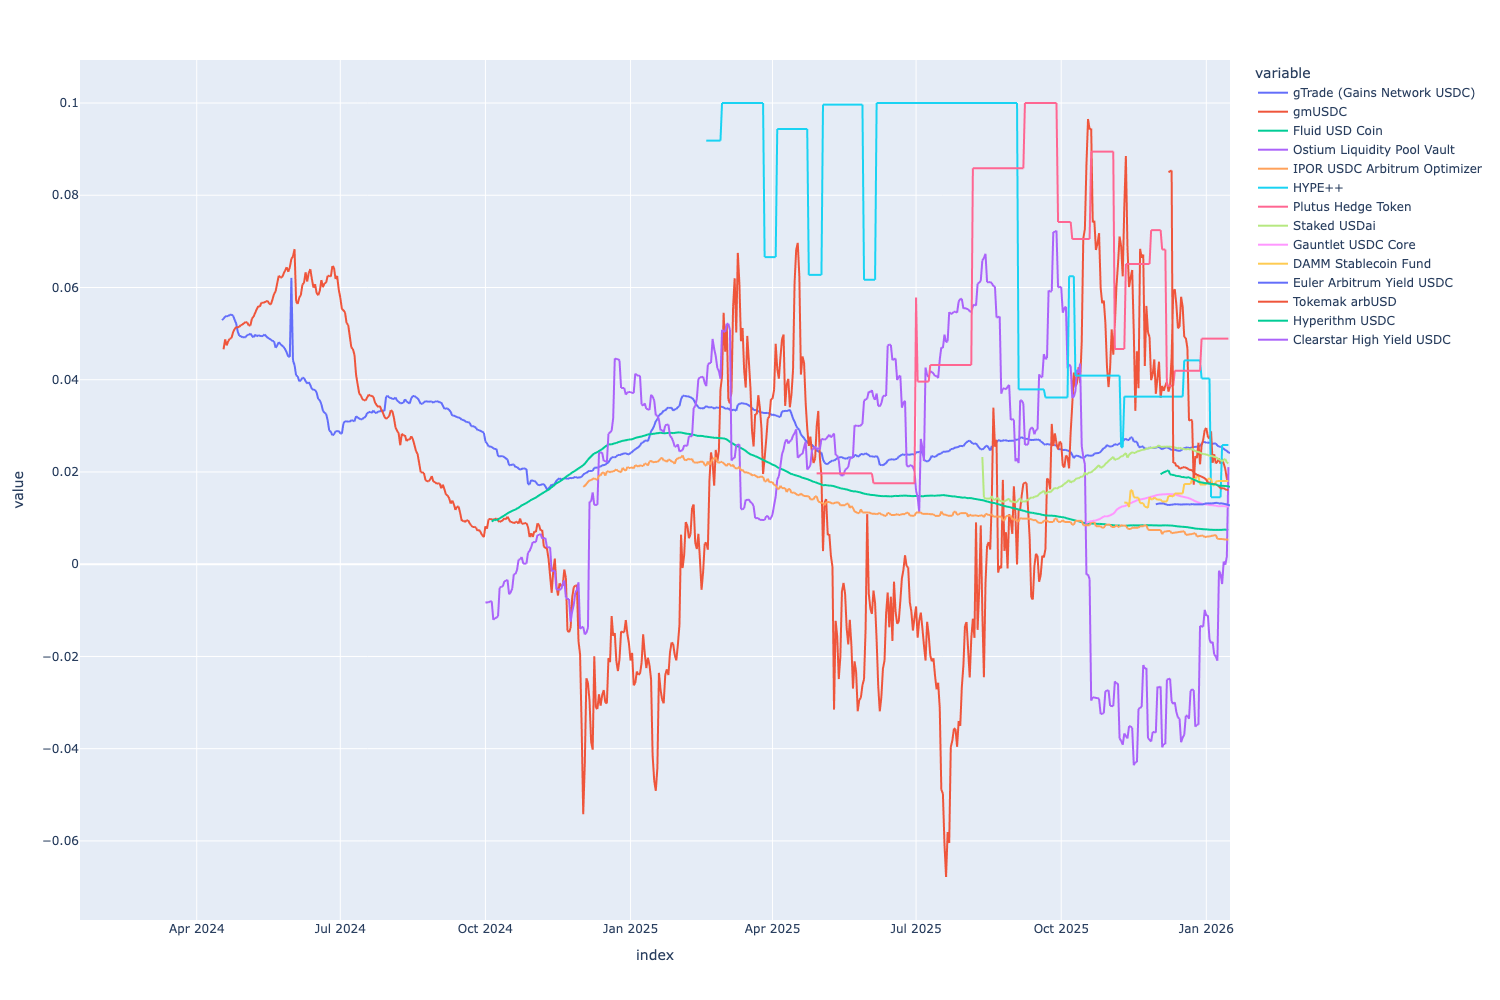

In [ ]:
# Take signal (pair_id, timestamp) multiindex series and get it to human-readable form

# Take signal (pair_id, timestamp) multiindex series and get it to human-readable form
rolling_returns_series = indicator_data.get_indicator_data_pairs_combined("rolling_returns")
rolling_returns_df = rolling_returns_series.unstack(level='pair_id')

# Rename pair_id columns to human-readable vault/pair names
print("Rolling returns:")
rolling_returns_df.columns = [
    strategy_universe.get_pair_by_id(pair_id).get_ticker()
    for pair_id in rolling_returns_df.columns
]
display(rolling_returns_df.tail(5))

print("Derived signal with inclusion mask:")
signal_series = indicator_data.get_indicator_data_pairs_combined("signal")
signal_df = signal_series.unstack(level='pair_id')

# Rename pair_id columns to human-readable vault/pair names
signal_df.columns = [
    strategy_universe.get_pair_by_id(pair_id).get_ticker()
    for pair_id in signal_df.columns
]

display(signal_df.tail(5))

fig = chart_renderer.render(signal_comparison)
fig.show()

## Vault TVL and share price data

- Examine returns of the vaults used in this backtest

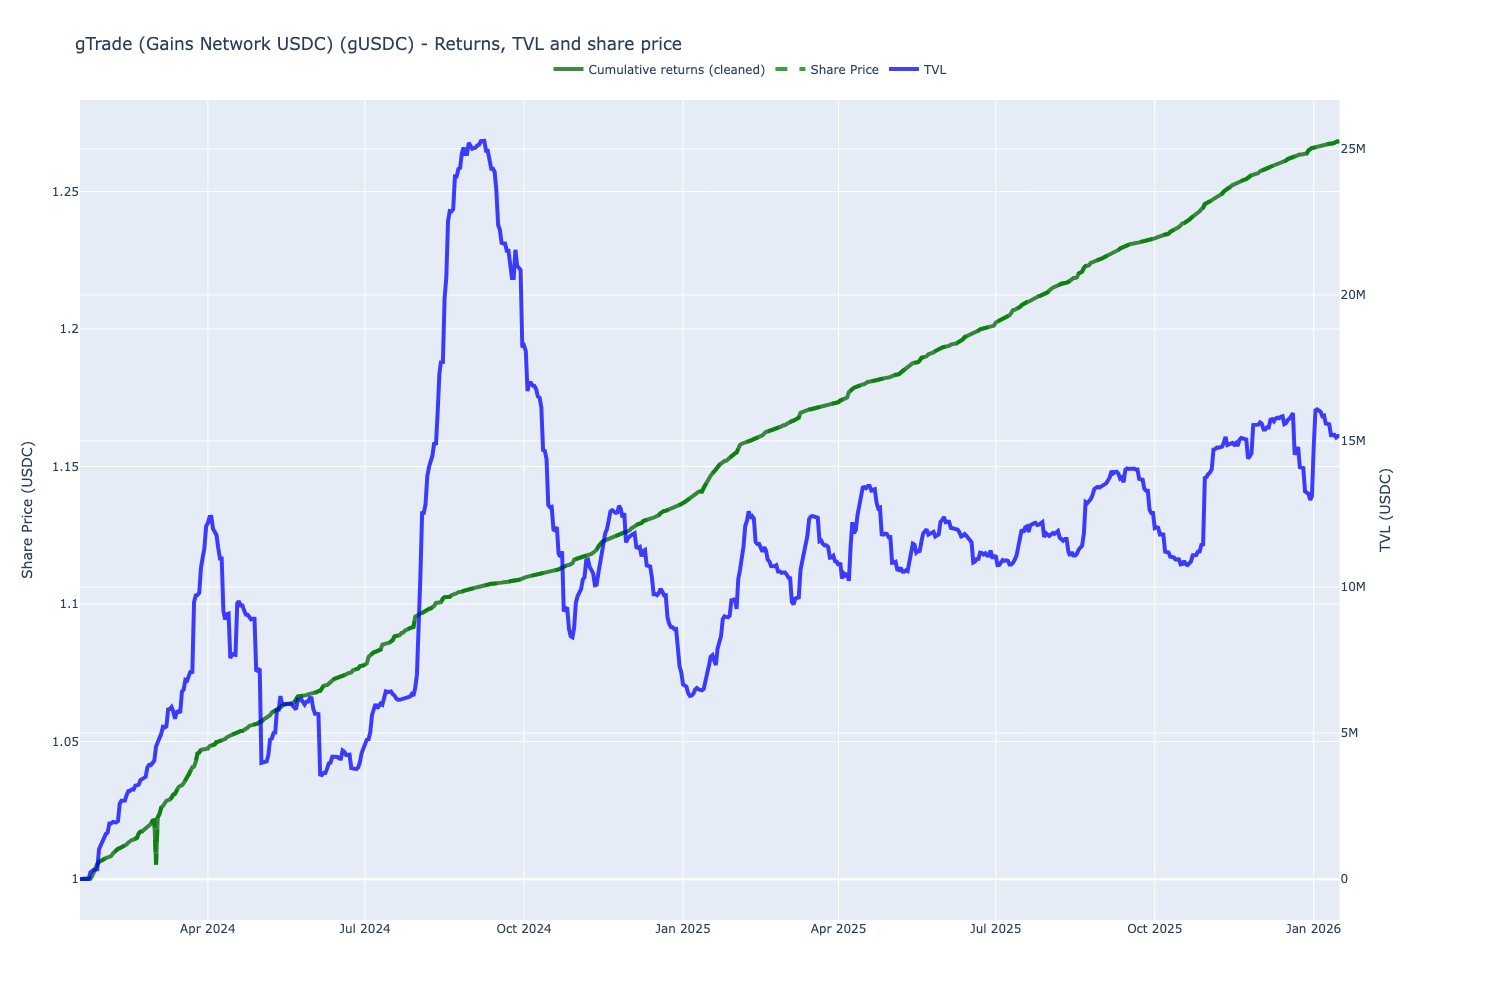

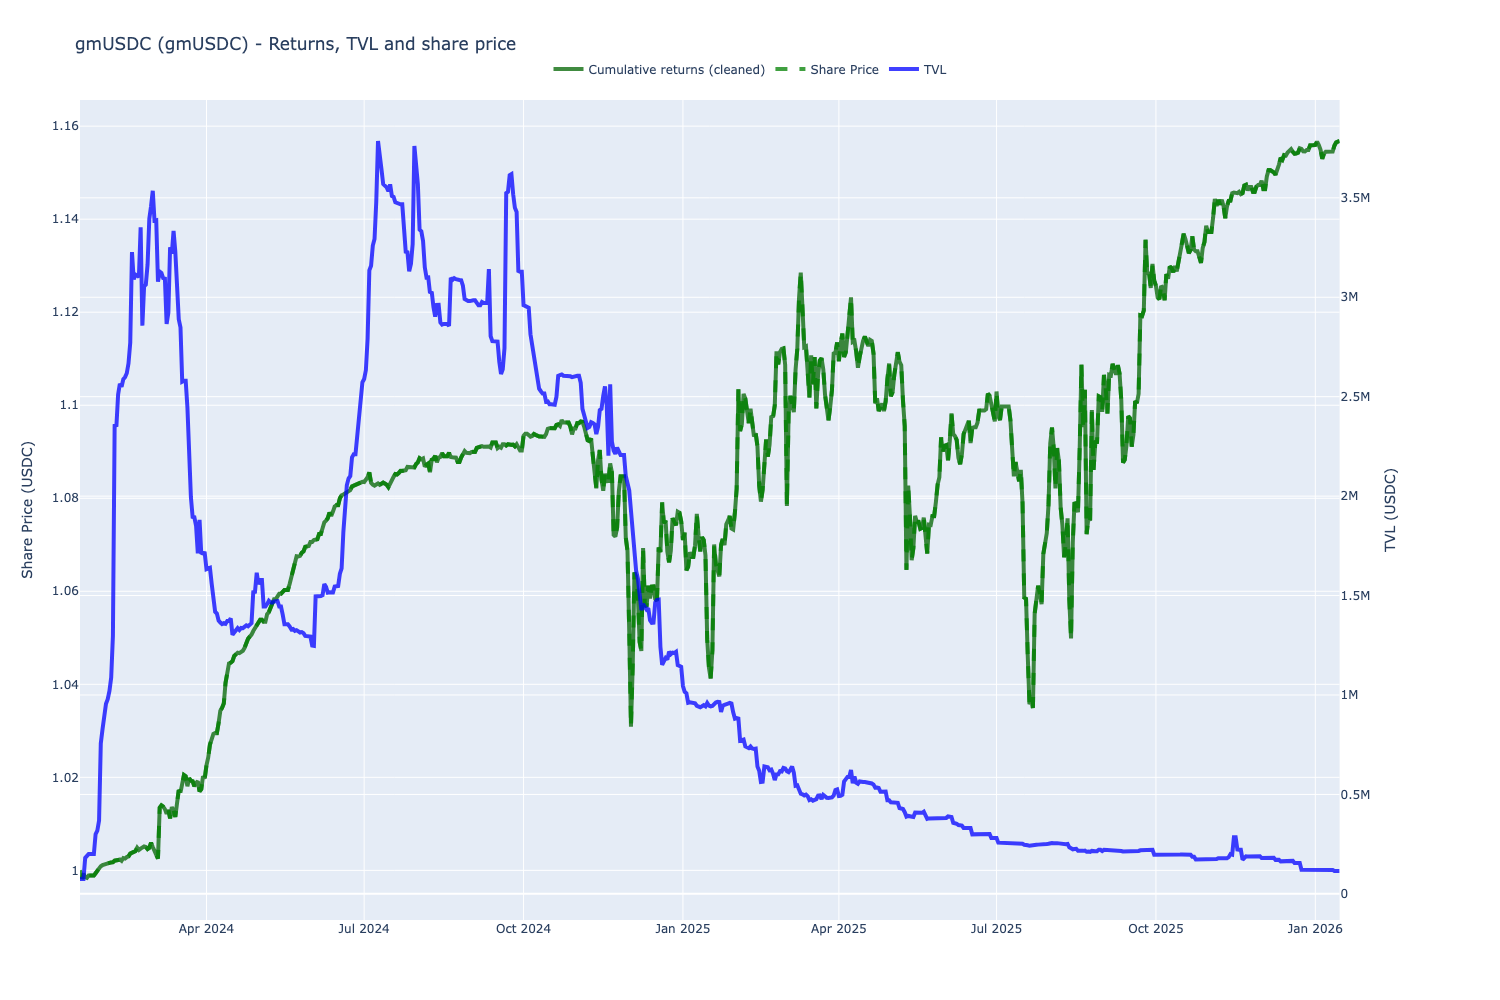

In [ ]:
from tradeexecutor.analysis.vault import visualise_vaults

figures = chart_renderer.render(all_vaults_share_price_and_tvl)
for fig in figures:
    fig.show()

# Time range for backtest

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [ ]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2025-01-01 00:00:00 - 2026-01-15 00:00:00


# Algorithm and backtest

- Run the backtest

In [ ]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any
from tradeexecutor.strategy.pandas_trader.yield_manager import YieldManager, YieldRuleset, YieldWeightingRule, YieldDecisionInput
from tradeexecutor.strategy.execution_context import ExecutionContext, ExecutionMode


_cached_start_times: dict[int, pd.Timestamp] = {}

def create_yield_rules(
    timestamp: pd.Timestamp,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
) -> YieldRuleset:
    """Create yield rules for the strategy."""
    weights = []
    for vault_spec in VAULTS:
        vault_pair = strategy_universe.get_pair_by_smart_contract(vault_spec[1])
        if vault_pair not in _cached_start_times:
            price_df = strategy_universe.data_universe.candles.get_samples_by_pair(vault_pair.internal_id)
            assert price_df is not None
            index_entry = price_df.index[0]
            assert isinstance(index_entry, tuple)
            _cached_start_times[vault_pair] = index_entry[1]
        
        availability = _cached_start_times[vault_pair]
        if timestamp > availability:
            weights.append(
            YieldWeightingRule(
                pair=vault_pair, 
                max_concentration=1.00,
                max_pool_participation=0.05,
            ),
            )

    if len(weights) == 0:
        return None
    
    return YieldRuleset(
        position_allocation=parameters.allocation,
        buffer_pct=parameters.directional_trade_yield_buffer_pct,
        cash_change_tolerance_usd=parameters.yield_flow_dust_threshold,
        weights=weights
    )


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    portfolio = position_manager.get_current_portfolio()
    equity = portfolio.get_total_equity()
    
    # Live trading automation not yet enabled -
    # manually check positions while the strategy is in beta mode
    if input.execution_context.mode != ExecutionMode.backtesting:
        return []
            
    # Build signals for each pair
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )

    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    signal_count = 0
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        if not state.is_good_pair(pair):
            # Tradeable flag set to False, etc.
            continue

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal

        if weight < 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    equity = portfolio.get_total_equity()
    portfolio_target_value = equity * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    #
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=0.0,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=False,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)

    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd

    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        sell_rebalance_min_threshold=parameters.sell_rebalance_min_threshold,
        execution_context=input.execution_context,
    )

    # # Move cash in and out yield managed to cover spot positions
    # yield_result = None 
    # if parameters.use_managed_yield:

    #     rules = create_yield_rules(
    #         timestamp,
    #         parameters, 
    #         strategy_universe,
    #     )

    #     if rules is not None:
    #         yield_manager = YieldManager(
    #             position_manager=position_manager,
    #             rules=rules,
    #         )

    #         yield_input = YieldDecisionInput(
    #             execution_mode=input.execution_context.mode,
    #             cycle=input.cycle,
    #             timestamp=timestamp,
    #             total_equity=state.portfolio.get_total_equity(),
    #             directional_trades=trades,
    #             size_risk_model=size_risk_model,
    #             pending_redemptions=position_manager.get_pending_redemptions(),
    #         )

    #         yield_result = yield_manager.calculate_yield_management(yield_input)
    #         trades += yield_result.trades
        
    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)

        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report,
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

all_trades = list(state.portfolio.get_all_trades())
trade_count = len(all_trades)
print(f"Backtesting completed, backtested strategy made {trade_count} trades, {state.cycle} cycles executed, last cycle at {state.last_cycle_at} w/ open positions {state.last_open_positions_cycle_at}")
if len(all_trades) > 0:
    print(f"First trade at {all_trades[0].executed_at}, last trade at {all_trades[-1].executed_at}")

# Add state to the further charts
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    state=state,
)


Reading cached indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusi…

Using indicator cache /Users/moo/.cache/indicators/arbitrum_1d_15_2024-01-18-2026-01-16_ff


  0%|          | 0/32745600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 264 trades, 55 cycles executed, last cycle at 2026-01-12 00:01:01 w/ open positions 2026-01-12 00:01:01
First trade at 2024-12-30 00:00:00, last trade at 2026-01-12 00:00:00


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [ ]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

df = chart_renderer.render(performance_metrics)
display(df)

Strategy                  ETH
Start Period                        2024-12-30           2024-12-30
End Period                          2026-01-12           2026-01-12
Risk-Free Rate                            0.0%                 0.0%
Time in Market                           15.0%                98.0%
Cumulative Return                        12.9%              -14.95%
CAGR﹪                                   12.43%              -14.47%
Sharpe                                    3.67                 0.15
Prob. Sharpe Ratio                      100.0%               56.23%
Smart Sharpe                              3.54                 0.15
Sortino                                  29.17                 0.23
Smart Sortino                            28.12                 0.22
Sortino/√2                               20.63                 0.16
Smart Sortino/√2                         19.88                 0.16
Omega                                    11.73                11.73
Max Drawdown                            -0.28%              -60.05%
Longest DD Days                             21                  194
Volatility (ann.)                         3.2%               73.88%
Calmar                                   44.85                -0.24
Skew                                      7.64                 0.55
Kurtosis                                 76.61                 4.23
Expected Daily                           0.03%               -0.04%
Expected Monthly                         0.87%               -1.15%
Expected Yearly                          4.13%               -5.25%
Kelly Criterion                         72.84%                 2.8%
Risk of Ruin                              0.0%                 0.0%
Daily Value-at-Risk                     -0.24%               -6.33%
Expected Shortfall (cVaR)               -0.24%               -6.33%
Max Consecutive Wins                         1                    9
Max Consecutive Losses                       1                    6
Gain/Pain Ratio                          10.73                 0.02
Gain/Pain (1M)                               -                 0.12
Payoff Ratio                               3.0                 1.05
Profit Factor                            11.73                 1.02
Common Sense Ratio                           -                 1.16
CPC Index                                28.03                 0.54
Tail Ratio                                   -                 1.14
Outlier Win Ratio                        21.85                 2.39
Outlier Loss Ratio                        1.31                 1.74
MTD                                      0.17%                4.14%
3M                                        1.9%              -17.58%
6M                                       5.36%                 4.5%
YTD                                      0.17%                4.14%
1Y                                      12.75%                -5.8%
3Y (ann.)                               12.43%              -14.47%
5Y (ann.)                               12.43%              -14.47%
10Y (ann.)                              12.43%              -14.47%
All-time (ann.)                         12.43%              -14.47%
Best Day                                 2.14%               21.79%
Worst Day                                -0.2%              -14.75%
Best Month                               2.21%                48.7%
Worst Month                               0.0%               -32.2%
Best Year                               12.71%                4.14%
Worst Year                                0.0%              -18.33%
Avg. Drawdown                           -0.14%              -22.32%
Avg. Drawdown Days                          15                   60
Recovery Factor                          43.97                  0.2
Ulcer Index                                0.0                 0.31
Serenity Index                          175.04                 0.03
Avg. Up Month             

# Equity curve

- Equity curve shows how your strategy accrues value over time

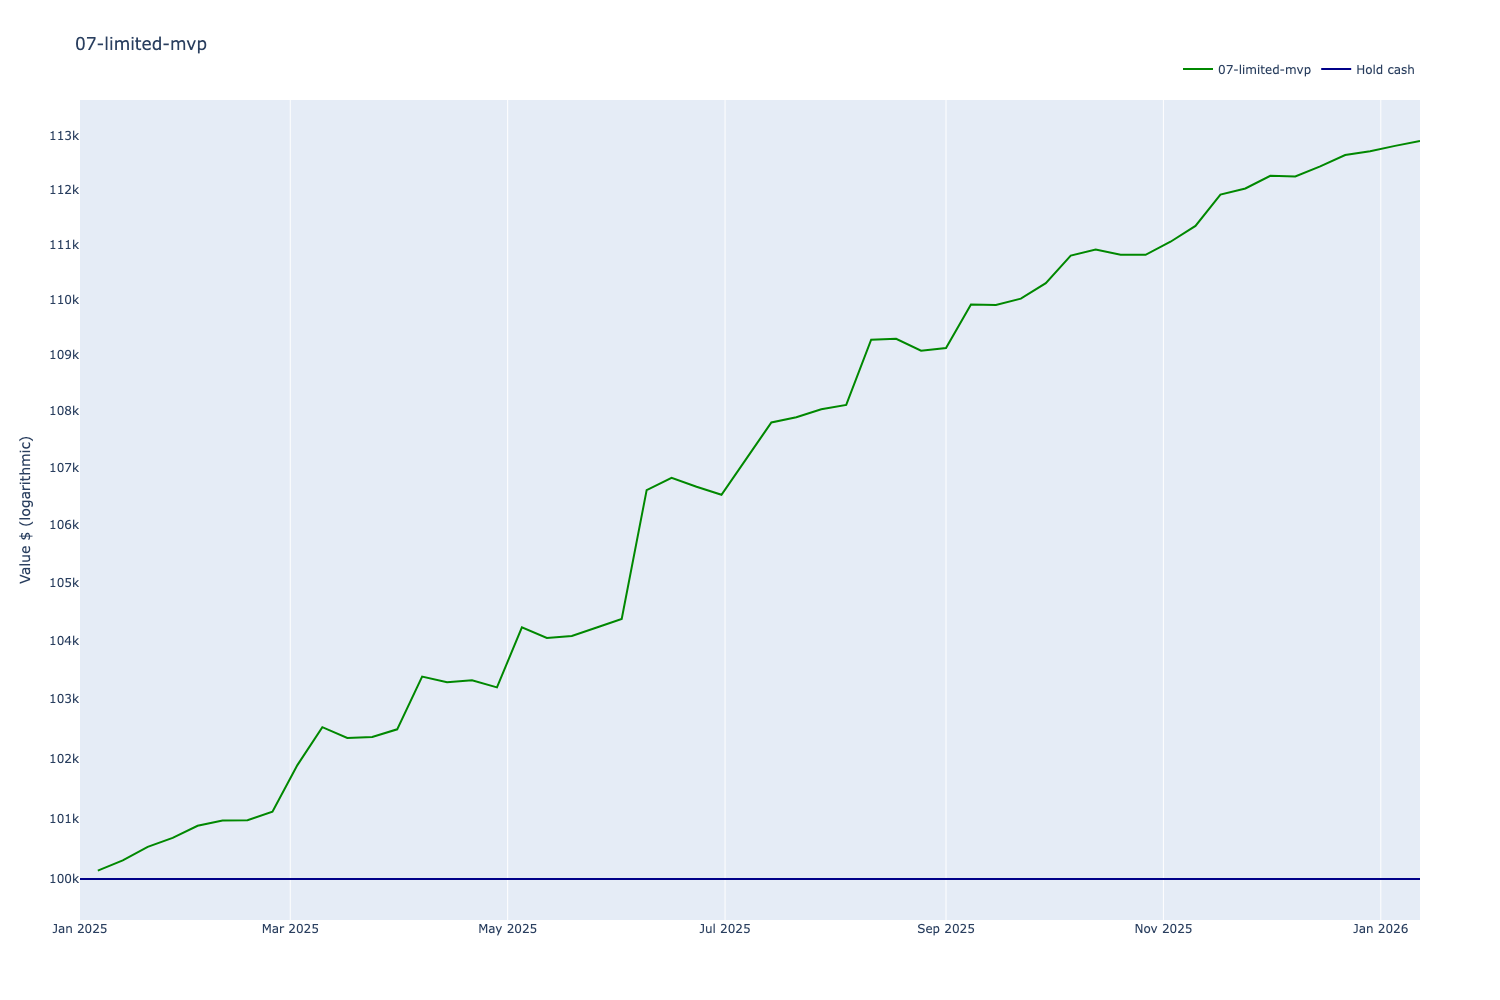

In [ ]:
fig = chart_renderer.render(
    equity_curve_with_benchmark, 
)

fig.show()

## Equity curve with drawdown

- Linear curve

In [ ]:

fig = chart_renderer.render(equity_curve_with_drawdown)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

## Volatiles only

In [ ]:
# fig = chart_renderer.render(volatile_weights_by_percent)
# fig.show()

print("Currently the strategy does not take directional positions")

Currently the strategy does not take directional positions


## Volatiles and non-volatiles

- Portfolio with cash, lending and vault positions

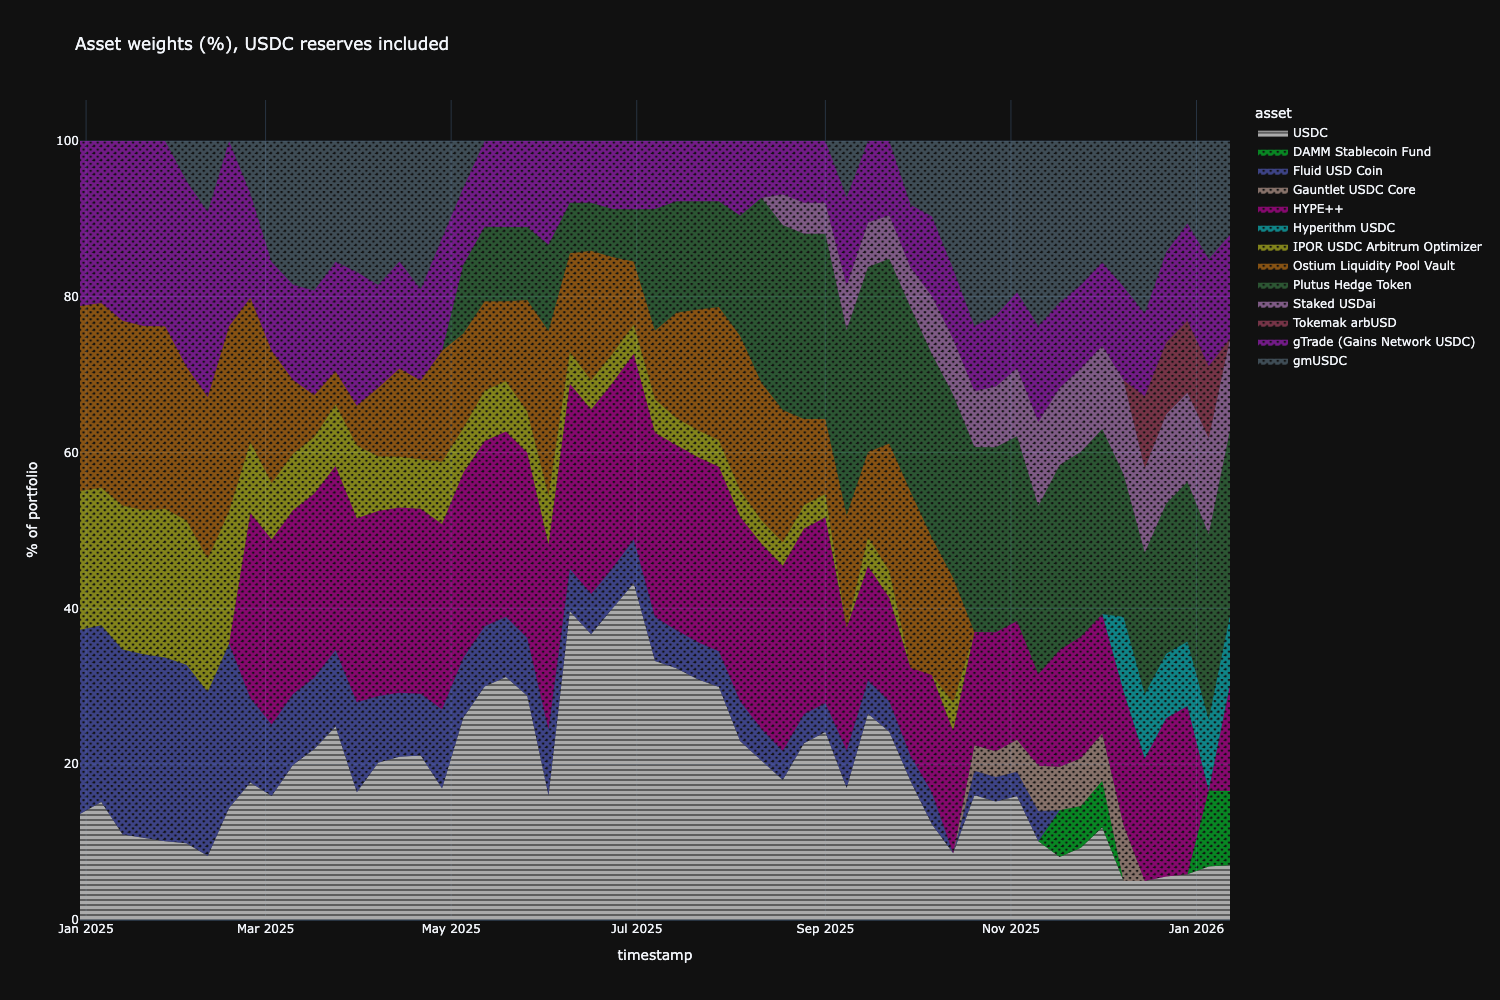

In [ ]:

fig = chart_renderer.render(volatile_and_non_volatile_percent)
fig.show()
    

## Portfolio equity curve breakdown by asset

- Where did we make the profit

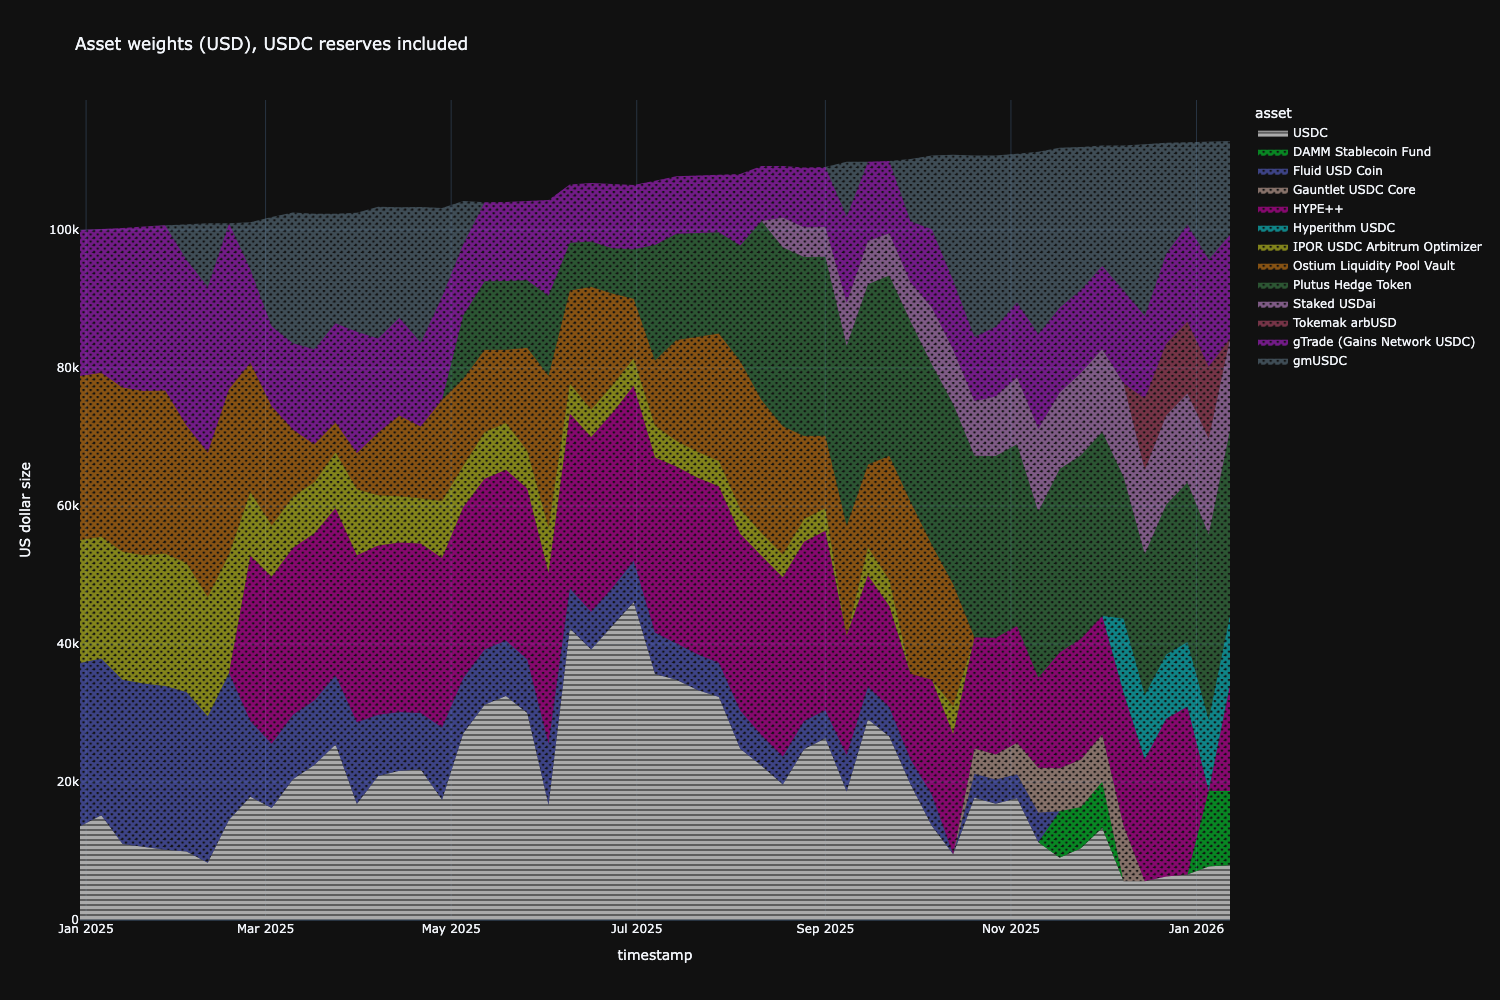

In [ ]:
fig = chart_renderer.render(equity_curve_by_asset)
fig.show()

## Weight allocation statistics



In [ ]:
stats = chart_renderer.render(weight_allocation_statistics)
display(stats)


At  \
Name                                                  
Max position (excluding USDC)   2026-01-05 00:00:00   
Min position (excluding USDC)   2025-08-11 00:00:00   
Mean position (excluding USDC)                        
Max position (excluding USDC)   2025-06-30 00:00:00   
Min position (excluding USDC)   2025-08-18 00:00:00   
Mean position (excluding USDC)                        
Max position (including USDC)   2025-06-30 00:00:00   
Min position (including USDC)   2025-08-11 00:00:00   
Mean position (including USDC)                        

                                                        Pair      Value Unit  
Name                                                                          
Max position (excluding USDC)             Plutus Hedge Token  26,793.02  USD  
Min position (excluding USDC)   IPOR USDC Arbitrum Optimizer   3,301.13  USD  
Mean position (excluding USDC)                                14,048.48  USD  
Max position (excluding USDC)                         HYPE++      41.94    %  
Min position (excluding USDC)   IPOR USDC Arbitrum Optimizer       3.69    %  
Mean position (excluding USDC)                                    16.22    %  
Max position (including USDC)                           USDC      43.23    %  
Min position (including USDC)   IPOR USDC Arbitrum Optimizer       3.02    %  
Mean position (including USDC)                                    13.96    %

# Positions at the end

Some example positions at the end


In [ ]:
stats = chart_renderer.render(positions_at_end)
display(stats)

token         value
position_id                          
3                 gUSDC  15049.370137
8              plvHedge  26793.017955
9                sUSDai  13269.855526
12               gmUSDC  13579.645846
17            hyperUSDC  10122.924519
19           DAMMstable  10742.538859
20               HYPE++  15379.631424

# Strategy thinking

- At the end of strategy
- Reverse order - last timestamp first

In [ ]:
df = chart_renderer.render(last_messages)
display(df)

# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [ ]:
df = chart_renderer.render(alpha_model_diagnostics)
display(df)

Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                         
ipUSDCfusion-USDC  0.005472             -            NaN          0.000000   
fUSDC-USDC         0.007457             -            NaN          0.000000   
gtUSDCc-USDC       0.012594             -            NaN          0.000000   
eUSDC-5-USDC       0.013181             -            NaN          0.000000   
arbUSD-USDC        0.016434             -            NaN          0.000000   
hyperUSDC-USDC     0.017010  10122.924519   10122.924519       -202.950995   
DAMMstable-USD₮0   0.018052  10742.538859   10742.538859       -257.020359   
sUSDai-USDai       0.022298  13269.855526   13269.855526       -677.805778   
gmUSDC-USDC        0.022819  13579.645846   13579.645846      -3529.158550   
gUSDC-USDC         0.025289  15049.370137   15049.370137       -497.841711   
HYPE++-USDC        0.025844  15379.631424   15379.631424      15379.631424   
plvHedge-USDC      0.048923  26814.562059   26814.562059         21.544104   

                   Weights (raw)  Weights (norm/cap)  Old weight  \
Pair                                                               
ipUSDCfusion-USDC       0.000000            0.000000    0.000000   
fUSDC-USDC              0.000000            0.000000    0.000000   
gtUSDCc-USDC            0.000000            0.000000    0.000000   
eUSDC-5-USDC            0.000000            0.000000    0.000000   
arbUSD-USDC             0.000000            0.000000    0.000000   
hyperUSDC-USDC          0.017010            0.096447    0.098209   
DAMMstable-USD₮0        0.018052            0.102350    0.104616   
sUSDai-USDai            0.022298            0.126430    0.132655   
gmUSDC-USDC             0.022819            0.129381    0.162721   
gUSDC-USDC              0.025289            0.143384    0.147868   
HYPE++-USDC             0.025844            0.146531    0.000000   
plvHedge-USDC           0.048923            0.255478    0.254827   

                       Flipping        TVL  \
Pair                                         
ipUSDCfusion-USDC  none -> spot          0   
fUSDC-USDC         none -> spot          0   
gtUSDCc-USDC       none -> spot          0   
eUSDC-5-USDC       none -> spot          0   
arbUSD-USDC        none -> spot          0   
hyperUSDC-USDC          no flip   24453779   
DAMMstable-USD₮0        no flip    1597360   
sUSDai-USDai            no flip  315025885   
gmUSDC-USDC             no flip     120575   
gUSDC-USDC              no flip   15203312   
HYPE++-USDC        none -> spot    4084242   
plvHedge-USDC           no flip     245578   

                                                               Flags  
Pair                                                                  
ipUSDCfusion-USDC                                                     
fUSDC-USDC                                                            
gtUSDCc-USDC                                                          
eUSDC-5-USDC                                                          
arbUSD-USDC                                                           
hyperUSDC-USDC                                                        
DAMMstable-USD₮0                                                      
sUSDai-USDai                                                          
gmUSDC-USDC                                                           
gUSDC-USDC                                                            
HYPE++-USDC                                                           
plvHedge-USDC      individual_trade_size_too_small, capped_by_con...

# Trading pair breakdown

- Trade success for each trading pair



In [ ]:
df = chart_renderer.render(trading_pair_breakdown)
display(df)

# Trading metrics

- Trading cost, etc.

In [ ]:
df = chart_renderer.render(trading_metrics)
display(df)


# Interest accrued

- How much profit our non-volatile positions generated

## Lending pools

- Calculate interest from lending pools (Aave, etc)

In [ ]:
df = chart_renderer.render(lending_pool_interest_accrued)
display(df)

Metric  Value
0  Credit position count      0

# Vault performance

- Analyse the performance of our vaults

## Vault statistics 

- Calculate interest accrued on different vaults for the strategy

In [ ]:
df = chart_renderer.render(vault_statistics)
display(df)

Metric              Value
0                Position count                 20
1         Total interest earned      12,903.42 USD
2                  Avg interest             -1.96%
3                  Min interest            -63.08%
4                  Max interest             16.56%
5  Avg credit position duration  117 days, 6:00:00
6         Total deposit flow in     463,877.87 USD
7                   Min deposit         509.12 USD
8                   Avg deposit       3,740.95 USD
9                   Max deposit      24,014.53 USD

## Vault position list

- Display individual positions taken in the vaults

In [ ]:
df = chart_renderer.render(all_vault_positions)
display(df)

Vault     Opened               Closed  \
Id                                                                 
3    gTrade (Gains Network USDC) 2024-12-30                    -   
1    Ostium Liquidity Pool Vault 2024-12-30  2025-10-20 00:00:00   
2                 Fluid USD Coin 2024-12-30  2025-10-13 00:00:00   
4   IPOR USDC Arbitrum Optimizer 2024-12-30  2025-09-08 00:00:00   
5                         gmUSDC 2025-02-03  2025-02-17 00:00:00   
7                         gmUSDC 2025-02-24  2025-05-12 00:00:00   
6                         HYPE++ 2025-02-24  2026-01-05 00:00:00   
8             Plutus Hedge Token 2025-05-05                    -   
9                   Staked USDai 2025-08-18                    -   
10                        gmUSDC 2025-09-08  2025-09-15 00:00:00   
11  IPOR USDC Arbitrum Optimizer 2025-09-15  2025-09-29 00:00:00   
12                        gmUSDC 2025-09-29                    -   
13  IPOR USDC Arbitrum Optimizer 2025-10-13  2025-10-20 00:00:00   
15                Fluid USD Coin 2025-10-20  2025-11-17 00:00:00   
14            Gauntlet USDC Core 2025-10-20  2025-12-15 00:00:00   
16          DAMM Stablecoin Fund 2025-11-17  2025-12-08 00:00:00   
17                Hyperithm USDC 2025-12-08                    -   
18                Tokemak arbUSD 2025-12-15  2026-01-12 00:00:00   
19          DAMM Stablecoin Fund 2026-01-05                    -   
20                        HYPE++ 2026-01-12                    -   

   Profit % annualised Profit USD Price on open Price on close Price diff %  \
Id                                                                            
3                 2.57    1507.39          1.14           1.27        11.59   
1                 0.95     648.70          1.03           1.11         7.45   
2                 2.24     593.55          1.04           1.09         4.98   
4                 2.05     361.96          1.02           1.06         3.65   
5               -40.60    -182.94          1.10           1.08        -2.26   
7                -0.25     -13.51          1.10           1.08        -2.36   
6                16.74    6086.30          1.09           1.41        29.52   
8                10.56    2947.66          1.02           1.19        17.14   
9                 4.74     326.37          1.03           1.06         3.66   
10              -46.99     -96.35          1.11           1.09        -1.21   
11                4.18       6.41          1.06           1.06         0.16   
12                4.23     536.53          1.13           1.16         2.36   
13                3.49       2.64          1.07           1.07         0.07   
15                2.81       9.15          1.09           1.09         0.25   
14                3.81      47.51          1.01           1.02         0.87   
16                6.16      25.59          1.02           1.02         0.41   
17                4.13      49.48          1.02           1.03         0.51   
18                4.69      36.60          1.09           1.09         0.35   
19                3.51      10.38          1.03           1.03         0.09   
20                0.00       0.00          1.43           1.43            -   

   Price diff % ann.  Deposits  Redeems  
Id                                       
3              12.10        23       20  
1               6.00        18       22  
2               3.91        10       22  
4               2.52         9       17  
5              -0.09         2        1  
7              -0.50         7        5  
6              25.47         9       14  
8              11.97        11       12  
9               1.50        10        6  
10             -0.02         1        1  
11              0.01         1        2  
12              0.70         8        8  
13              0.00         1        1  
15              0.02         2        1  
14              0.13         5        2  
16              0.02         2        2  
17              0.05         2     

## Vault individual position timeline

- Show one of the vaults

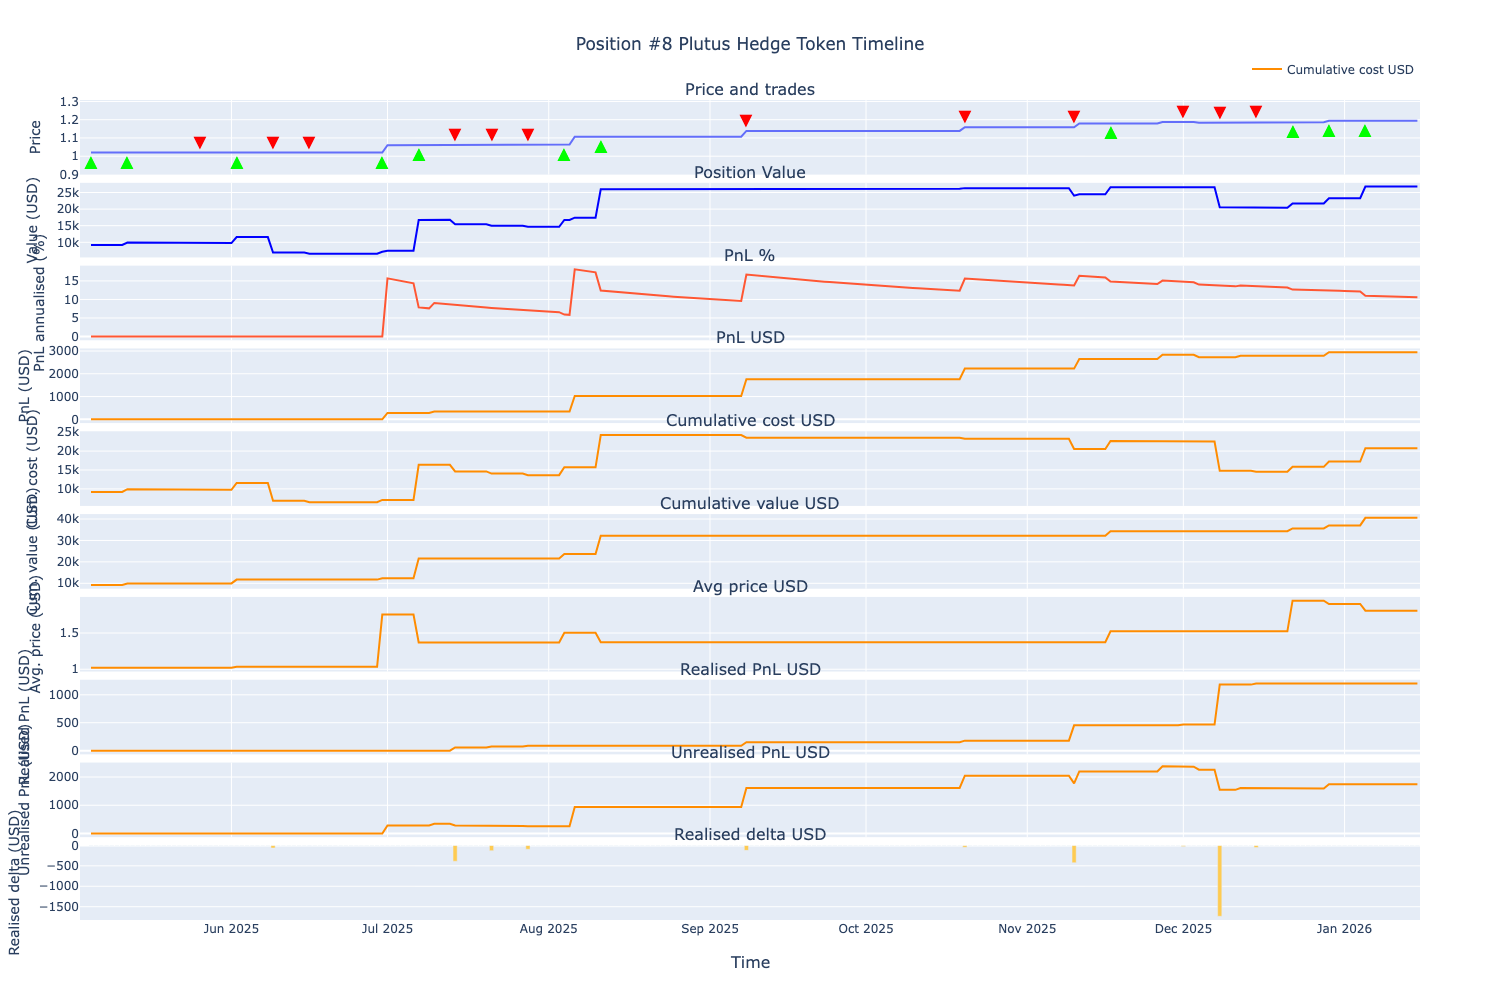

quantity        delta  executed_price  fee  cumulative_cost  \
timestamp                                                                     
2025-05-05   9031.036444  9031.036444        1.019689  0.0      9208.848521   
2025-05-06   9031.036444     0.000000        1.019689  0.0      9208.848521   
2025-05-11   9031.036444     0.000000        1.019689  0.0      9208.848521   
2025-05-12   9743.087450   712.051005        1.019689  0.0      9934.919098   
2025-05-13   9743.087450     0.000000        1.019689  0.0      9934.919098   
2025-05-25   9743.087450     0.000000        1.019689  0.0      9934.919098   
2025-05-26   9584.702216  -158.385233        1.019689  0.0      9773.415418   
2025-05-27   9584.702216     0.000000        1.019689  0.0      9773.415418   
2025-06-01   9584.702216     0.000000        1.019689  0.0      9773.415418   
2025-06-02  11339.176377  1754.474161        1.019689  0.0     11562.433421   
2025-06-03  11339.176377     0.000000        1.019689  0.0     11562.433421   
2025-06-08  11339.176377     0.000000        1.019689  0.0     11562.433421   
2025-06-09   6772.109539 -4567.066839        1.019689  0.0      6840.396955   
2025-06-10   6772.109539     0.000000        1.019689  0.0      6840.396955   
2025-06-15   6772.109539     0.000000        1.019689  0.0      6840.396955   
2025-06-16   6436.292137  -335.817402        1.019689  0.0      6493.184603   
2025-06-17   6436.292137     0.000000        1.019689  0.0      6493.184603   
2025-06-29   6436.292137     0.000000        1.019689  0.0      6493.184603   
2025-06-30   7024.765050   588.472913        1.019689  0.0      7093.243959   
2025-07-01   7024.765050     0.000000        1.019689  0.0      7093.243959   
2025-07-06   7024.765050     0.000000        1.019689  0.0      7093.243959   
2025-07-07  15775.645679  8750.880628        1.060063  0.0     16369.728731   
2025-07-08  15775.645679     0.000000        1.060063  0.0     16369.728731   
2025-07-13  15775.645679     0.000000        1.060063  0.0     16369.728731   
2025-07-14  14506.444580 -1269.201098        1.063733  0.0     14631.901002   
2025-07-15  14506.444580     0.000000        1.063733  0.0     14631.901002   
2025-07-20  14506.444580     0.000000        1.063733  0.0     14631.901002   
2025-07-21  14085.986627  -420.457954        1.063733  0.0     14056.197521   
2025-07-22  14085.986627     0.000000        1.063733  0.0     14056.197521   
2025-07-27  14085.986627     0.000000        1.063733  0.0     14056.197521   
2025-07-28  13778.918227  -307.068400        1.063733  0.0     13635.750375   
2025-07-29  13778.918227     0.000000        1.063733  0.0     13635.750375   
2025-08-03  13778.918227     0.000000        1.063733  0.0     13635.750375   
2025-08-04  15732.871280  1953.953053        1.063733  0.0     15714.234718   
2025-08-05  15732.871280     0.000000        1.063733  0.0     15714.234718   
2025-08-10  15732.871280     0.000000        1.063733  0.0     15714.234718   
2025-08-11  23438.942009  7706.070729        1.107233  0.0     24246.650529   
2025-08-12  23438.942009     0.000000        1.107233  0.0     24246.650529   
2025-09-07  23438.942009     0.000000        1.107233  0.0     24246.650529   
2025-09-08  22922.641963  -516.300046        1.138729  0.0     23537.116043   
2025-09-09  22922.641963     0.000000        1.138729  0.0     23537.116043   
2025-10-19  22922.641963     0.000000        1.138729  0.0     23537.116043   
2025-10-20  22709.138582  -213.503381        1.158908  0.0     23243.705238   
2025-10-21  22709.138582     0.000000        1.158908  0.0     23243.705238   
2025-11-09  22709.138582     0.000000        1.158908  0.0     23243.705238   
2025-11-10  20739.450766 -1969.687816        1.158908  0.0     20536.826855   
2025-11-11  20739.450766     0.000000        1.158908  0.0     20536.826855   
2025-11-16  20739.450766     0.000000        1.158908  0.0     20536.826855   
2025-11-17  22537.984420  1798.533654        1.179304  0.0     226

In [ ]:
pair = strategy_universe.get_pair_by_smart_contract(address=VAULTS[0][1])

chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    pairs=[pair],
    state=state,
)

fig, df = chart_renderer.render(vault_position_timeline)

if fig is not None:
    display(fig)

if df is not None:
    display(df)